In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## EDA

In [88]:
df = pd.read_excel('../data/timeseries_data.xlsx', parse_dates=[0]).dropna()

In [89]:
df.head()

,DATETIME,HB_NORTH (RTLMP),ERCOT (WIND_RTI),ERCOT (GENERATION_SOLAR_RT),ERCOT (RTLOAD),HOURENDING,MARKETDAY,PEAKTYPE,MONTH,YEAR
0,2017-01-01 01:00:00,23.3575,2155.31,0.0,29485.791355,1,2017-01-01,OFFPEAK,JANUARY,2017
1,2017-01-01 02:00:00,21.4650,2313.81,0.0,28911.565913,2,2017-01-01,OFFPEAK,JANUARY,2017
2,2017-01-01 03:00:00,20.7350,2587.68,0.0,28238.258175,3,2017-01-01,OFFPEAK,JANUARY,2017
3,2017-01-01 04:00:00,20.2700,2748.65,0.0,27821.000513,4,2017-01-01,OFFPEAK,JANUARY,2017
4,2017-01-01 05:00:00,20.1200,2757.49,0.0,27646.942413,5,2017-01-01,OFFPEAK,JANUARY,2017


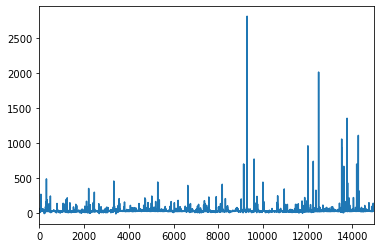

In [90]:
df['HB_NORTH (RTLMP)'].plot()
plt.show()

In [91]:
df.PEAKTYPE.value_counts()

WDPEAK     6964
OFFPEAK    4993
WEPEAK     3024
Name: PEAKTYPE, dtype: int64

In [92]:
df.YEAR.value_counts()

2017    8757
2018    6224
Name: YEAR, dtype: int64

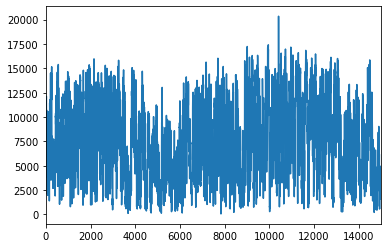

In [93]:
df['ERCOT (WIND_RTI)'].plot()
plt.show()

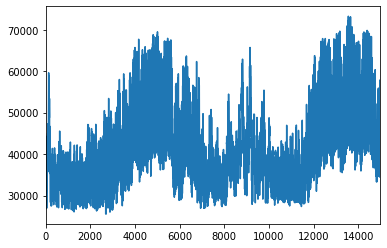

In [94]:
df['ERCOT (RTLOAD)'].plot()
plt.show()

## Feature Engineering

In [95]:
y = df['HB_NORTH (RTLMP)']
X = df.iloc[:,2:5]

In [96]:
X = X.join(pd.get_dummies(df.PEAKTYPE, prefix='peaktype').iloc[:,:2])

In [97]:
X = X.join(pd.get_dummies(pd.to_datetime(df.DATETIME).dt.quarter, prefix='Q').iloc[:,:3])

In [98]:
X['sin_day'] = np.sin((2*np.pi)/30*pd.to_datetime(df.MARKETDAY).dt.day)
X['cos_day'] = np.cos((2*np.pi)/30*pd.to_datetime(df.MARKETDAY).dt.day)

In [99]:
X['sin_hour'] = np.sin((2*np.pi)/24*df.HOURENDING)
X['cos_hour'] = np.cos((2*np.pi)/24*df.HOURENDING)

In [101]:
X.head()

,ERCOT (WIND_RTI),ERCOT (GENERATION_SOLAR_RT),ERCOT (RTLOAD),peaktype_OFFPEAK,peaktype_WDPEAK,Q_1,Q_2,Q_3,sin_day,cos_day,sin_hour,cos_hour
0,2155.31,0.0,29485.791355,1,0,1,0,0,0.207912,0.978148,0.258819,0.965926
1,2313.81,0.0,28911.565913,1,0,1,0,0,0.207912,0.978148,0.500000,0.866025
2,2587.68,0.0,28238.258175,1,0,1,0,0,0.207912,0.978148,0.707107,0.707107
3,2748.65,0.0,27821.000513,1,0,1,0,0,0.207912,0.978148,0.866025,0.500000
4,2757.49,0.0,27646.942413,1,0,1,0,0,0.207912,0.978148,0.965926,0.258819


## Model Development

In [119]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [102]:
x_train, x_test, y_train, y_test = train_test_split(X, y)

In [103]:
# compared two models, ridge regression and random forest regression, with r^2 and rmse
ridge = Ridge().fit(x_train, y_train)
r2_ridge = ridge.score(x_test, y_test)
r2_ridge

0.10824900929861325

In [122]:
ridge_preds = ridge.predict(x_test)
ridge_mse = mean_squared_error(y_test, ridge_preds)
np.sqrt(ridge_mse)

38.894489266058535

In [104]:
rfr = RandomForestRegressor().fit(x_train, y_train)
r2_rfr = rfr.score(x_test, y_test)
r2_rfr

0.43367448540141196

In [123]:
rfr_preds = rfr.predict(x_test)
rfr_mse = mean_squared_error(y_test, rfr_preds)
np.sqrt(rfr_mse)

30.995549274482006

In [111]:
# look at feature importance
feature_importances = pd.Series(rfr.feature_importances_,index=X.columns)
feature_importances.sort_values(ascending=False).round(3)

ERCOT (RTLOAD)                 0.340
ERCOT (GENERATION_SOLAR_RT)    0.292
ERCOT (WIND_RTI)               0.140
cos_day                        0.059
sin_hour                       0.051
sin_day                        0.040
cos_hour                       0.028
peaktype_WDPEAK                0.024
Q_3                            0.013
Q_2                            0.007
Q_1                            0.006
peaktype_OFFPEAK               0.001
dtype: float64

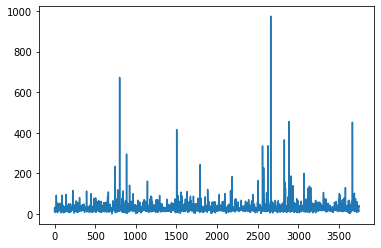

In [132]:
# plot predictions
plt.plot(rfr_preds)
plt.show()